<a href="https://colab.research.google.com/github/woow0n/cycle-predict/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4_%EC%BD%94%EB%93%9C%EC%A0%9C%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import warnings
import os
import random

from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet 
from google.colab import drive
warnings.filterwarnings(action='ignore')
drive.mount('/content/drive')

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

%cd '/content/drive/MyDrive/Colab Notebooks/cycle'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/cycle


In [ ]:
### 재현을 위한 시드고정 ###
rs = 813
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(rs)

In [ ]:
### 데이터로드 ###
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_original = pd.read_csv('train.csv')

In [ ]:
### 결측값 보간, 강수량 -> nan은 0일 것이라고 판단 ###
train['precipitation'] = train['precipitation'].fillna(0)
test['precipitation'] = test['precipitation'].fillna(0)

train.loc[train['sunshine_rate'] == 0, 'sunshine_sum'] = 0
test.loc[test['sunshine_rate'] == 0, 'sunshine_sum'] = 0

interpolate_list = list(train.isna().sum()[train.isna().sum()>0].index)

for col in interpolate_list:
    train[col] = train[col].interpolate()
    test[col] = test[col].interpolate()

In [ ]:
### 비온날에 대한 이용량 후보정을 위한 min_max ###
# 추후 예측값에 대하여 곱해줄 것
def my_minmax(array, a=0):
  min_, max_ = train['precipitation'].min(), train['precipitation'].max()
  minmax = a + ((array-min_)*(1-a))/(max_ - min_)
  return 1 - minmax

ww = my_minmax(train['precipitation'])
print(ww)

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
1090    1.000000
1091    0.987391
1092    0.998060
1093    1.000000
1094    1.000000
Name: precipitation, Length: 1095, dtype: float64


In [ ]:
### 시간의 흐름을 의미하는 feature ###
train['t'] = train.index
test['t'] = train.index.max() + test.index

In [ ]:
### 날짜 변수 생성 ## 
def make_day(train):
    train['date'] = pd.to_datetime(train['date'])
    train['year'] = train['date'].dt.year 
    train['weekday'] = train['date'].dt.weekday
    train['month'] = train['date'].dt.month
make_day(train)
make_day(test)

In [ ]:
### 미세먼지 기준 ###
def pm_(num, size):
  if size == '10':
    if num < 30:
      return 0
    elif num < 80:
      return 1
    elif num < 150:
      return 2
    else :
      return 3 
  else:
    if num < 15:
      return 0
    elif num < 35:
      return 1
    elif num < 75:
      return 2
    else :
      return 3 

train['pm_10'] = train['PM10'].map(lambda x : pm_(x,'10'))
test['pm_10'] = test['PM10'].map(lambda x : pm_(x,'10'))
train['pm_25'] = train['PM2.5'].map(lambda x : pm_(x,'25'))
test['pm_25'] = test['PM2.5'].map(lambda x : pm_(x,'25'))

In [ ]:
### 일주일간 평균기온과 당일의 온도차 ### 
# 첫 6번째날은 6일간만 5일번쨰날을 5일간만 이런식으로 계산 

def roll_days(roll_days, col_name):
  full_mean = pd.Series(np.concatenate([train[col_name].values, test[col_name].values]))
  full_mean_roll = full_mean.rolling(roll_days).mean()
  for i,idx in enumerate(range(roll_days-1,-1,-1)):
    if idx == 0:
      full_mean_roll[idx] = train[col_name][0]
    else:
      full_mean_roll[idx] = full_mean.rolling(roll_days-i).mean()[idx]
  
  train_roll = full_mean_roll.iloc[:-365].values
  test_roll = full_mean_roll.iloc[-365:].values

  return  train_roll, test_roll

temp_ma_train, temp_ma_test = roll_days(7, 'temp_mean') 

train['temp_ma'] = temp_ma_train
test['temp_ma'] = temp_ma_test

train['temp_ma'] = train['temp_ma'] - train['temp_mean']
test['temp_ma'] = test['temp_ma'] - test['temp_mean']

In [ ]:
### 전일과의 온도차 ### 
train['temp_diff'] = train['temp_mean'].diff(1).fillna(0)
test['temp_diff'] = test['temp_mean'].diff(1).fillna(0)

train['temp_diff'] = train['temp_diff'] - train['temp_mean']
test['temp_diff'] = test['temp_diff'] - test['temp_mean']

In [ ]:
### 체감온도 최대기준, 평균기준###
train['windchill_mean'] = 13.12 + 0.6215*train['temp_mean'] - 11.37*train['wind_mean']**(0.16) +0.3965*train['wind_mean']**(0.16)*train['temp_mean']
test['windchill_mean'] = 13.12 + 0.6215*test['temp_mean'] - 11.37*test['wind_mean']**(0.16) +0.3965*test['wind_mean']**(0.16)*test['temp_mean']

train['windchill_max'] = 13.12 + 0.6215*train['temp_highest'] - 11.37*train['wind_max']**(0.16) +0.3965*train['wind_max']**(0.16)*train['temp_highest']
test['windchill_max'] = 13.12 + 0.6215*test['temp_highest'] - 11.37*test['wind_max']**(0.16) +0.3965*test['wind_max']**(0.16)*test['temp_highest']

In [ ]:
### 체감온도와 실제온도의 차이 ###
train['ratio']= train['windchill_max']-train['temp_highest']
test['ratio']= test['windchill_max']-test['temp_highest']

In [ ]:
### 시간당 일조량 ### 
train['sun'] = train['sunshine_sum'] / train['sunshine_rate']
test['sun'] = test['sunshine_sum'] / test['sunshine_rate']

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

train['sun'] = train['sun'].fillna(0)
test['sun'] = test['sun'].fillna(0)

In [ ]:
### 습도, 불쾌지수 (일평균기온으로 계산) ###
train['humidity'] = train['humidity'] / 100
test['humidity'] = test['humidity'] / 100

train['discomfort'] = (1.8 * train['temp_mean']) - (0.55 * (1 - train['humidity']) * (1.8 * train['temp_mean'] - 26)) + 32
test['discomfort'] = (1.8 * test['temp_mean']) - (0.55 * (1 - test['humidity']) * (1.8 * test['temp_mean'] - 26)) + 32

In [ ]:
### 공휴일 컬럼 api 활용, join ###
### 크롤링 코드 ###
### 출처 : https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15012690
### 출처 : 한국천문연구원_특일 정보

# import requests
# import datetime
# from bs4 import BeautifulSoup
# import urllib.parse as urlparse
# import pandas as pd

# def get_request_query(url, operation, params, serviceKey):
#     params = urlparse.urlencode(params)
#     request_query = url + '/' + operation + '?' + params + '&' + 'serviceKey' + '=' + serviceKey
#     return request_query

# url =  'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService'
# operation = 'getRestDeInfo'
# mykey= '---------------'
# holiday_df = pd.DataFrame()
# for year in [2018, 2019, 2020, 2021]:
#     for month in range(1,13):

#         if month < 10:
#             month = '0' + str(month)
#         else:
#             month = str(month)
#         params = {'solYear':year, 'solMonth':month}

#         request_query = get_request_query(url, operation, params, mykey)

#         res = requests.get(request_query)
#         soup = BeautifulSoup(res.text, 'lxml')
#         items = soup.find_all('item')

#         for item in items:
#             day = item.locdate.get_text()
#             name = item.datename.get_text()
#             data = {'name':name , 'date':day}
#             holiday_df = holiday_df.append(data, ignore_index=True)

# holiday_df.to_csv('holiday_df.csv', index=False, encoding='cp949')

### 공휴일 변수 ###
holiday_df = pd.read_csv('holiday_df.csv', encoding='cp949')
holiday_df.rename(columns={'name':'holiday'}, inplace=True)
holiday_df['holiday'] = 1
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%Y%m%d')
train = train.merge(holiday_df, how='left', on='date')
test = test.merge(holiday_df, how='left', on='date')

train.loc[train['weekday'] > 4, 'holiday'] = 1
test.loc[test['weekday'] > 4, 'holiday'] = 1

# train['weekday'] = train['weekday'].astype('str')
# test['weekday'] = test['weekday'].astype('str')

train['holiday'] = train['holiday'].fillna(0)
test['holiday'] = test['holiday'].fillna(0)

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from itertools import combinations

drop_cols = ['date']
print(test.columns)

traincopy = train.copy()
testcopy = test.copy()

traincopy.drop(drop_cols, axis=1, inplace=True)
testcopy.drop(drop_cols, axis=1, inplace=True)

# StratifiedKFold를 위한 series
fold_criteria = (train['temp_highest']//5).astype('str')
traincopy = pd.get_dummies(traincopy)
testcopy = pd.get_dummies(testcopy)

X = traincopy.drop('rental', axis=1)
test_X = testcopy.copy()

# 9fold 시 가장 좋은 성능
lr = 0.05
ne = 1000
ns = 9
md = 4
es = 100

Index(['date', 'precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max', 't', 'year', 'weekday', 'month', 'pm_10',
       'pm_25', 'temp_ma', 'temp_diff', 'windchill_mean', 'windchill_max',
       'ratio', 'sun', 'discomfort', 'holiday'],
      dtype='object')


In [ ]:
### minmax scale ###
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test_X_ = scaler.transform(test_X)

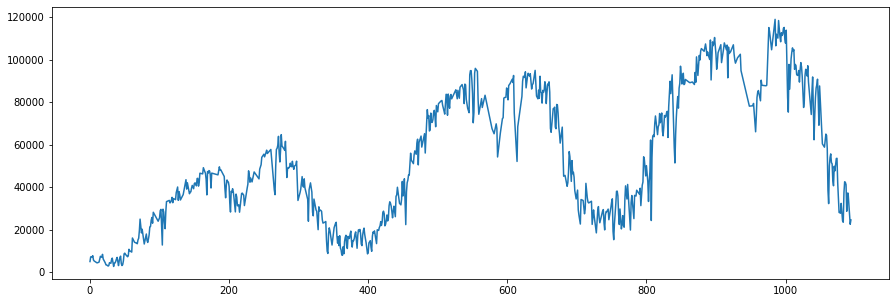

In [ ]:
### 시계열적인 특성을 제거하고 나머지 기상변수로 값을 예측하기 위해 prophet적합 ###
### prophet을 이용한 예측이전에 강수량에 따른 영향을 제거하고자 na처리하고 보간, 추후 비가온 날짜에 대해서 보정예정 ###

traincopy = train.copy()
traincopy.loc[traincopy['precipitation'] > 0, 'rental'] = np.nan
traincopy['rental'] = traincopy['rental'].interpolate()

prohet_df = traincopy[['date','rental']]
prohet_df.columns = ['ds','y']

plt.figure(figsize=(15,5))
plt.plot(prohet_df['y'])

In [ ]:
### 19년 대비 20년도의 증가치보다 20년 대비 21년 증가치가 더 클 것이라고 가정하고 예측 진행 ###

traincopy.groupby('year').mean()['rental'][2020]/traincopy.groupby('year').mean()['rental'][2019]

1.2712984221404813

In [ ]:
### 최적의 예측결과를 위해 optuna를 이용하여 파라미터튜닝 ###
### 데이터의 수가 적어 valset을 선정할 시 성능이 낮음
### 트렌드를 제거했다는 것을 수치화하기 위하여 정상성을 테스트하는 adf test의 value를 이용하여 튜닝

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objective_prophet(trial: Trial, X):
    param = {
        ## trend ##
        'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range', 0.8, 1, 0.05),
        'changepoint_prior_scale' : trial.suggest_discrete_uniform('changepoint_prior_scale', 0.05, 3, 0.01),
    }

    m = Prophet(
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            **param
            )
    m.fit(prohet_df)

    future = m.make_future_dataframe(periods=test.shape[0])
    forecast = m.predict(future)

    prohet_pred = forecast['trend']
    prohet_train = prohet_pred[:train.shape[0]]
    prohet_test = prohet_pred[-test.shape[0]:]

    original_rental = train['rental'].copy() 
    y = (train['rental'] / prohet_train)

    ss = adfuller(y)[0]
    ### 19년 대비 20년도의 증가치보다 20년 대비 21년 증가치가 더 클 것이라고 가정하고 예측 진행 ###
 
    if forecast['yhat'].iloc[-731:-365].mean()*1.3 > forecast['yhat'].iloc[-365:].mean():
      ss = 0  
    return ss

study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=813))
study.optimize(lambda trial : objective_prophet(trial,X), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

In [ ]:
best = study.best_trial.params
# best = {'changepoint_range': 0.8500000000000001, 'changepoint_prior_scale': 0.24}
print(best)

{'changepoint_range': 0.8500000000000001, 'changepoint_prior_scale': 0.24}


In [ ]:
m = Prophet(
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=best['changepoint_prior_scale'],
            changepoint_range=best['changepoint_range'],
            )
m.fit(prohet_df)
future = m.make_future_dataframe(periods=test.shape[0])
forecast = m.predict(future)

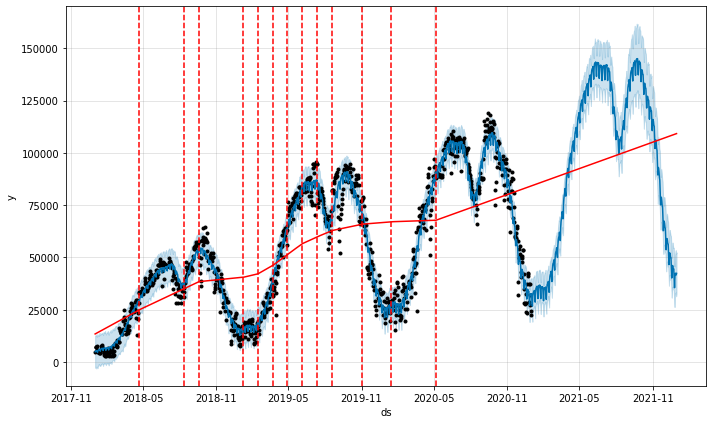

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

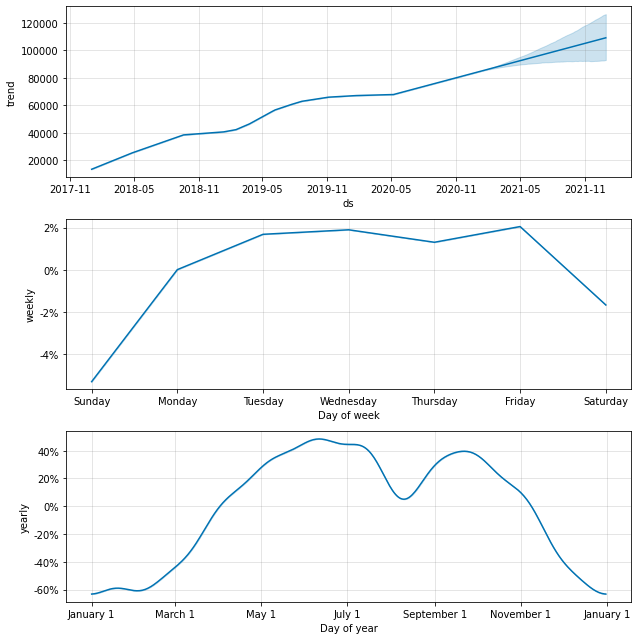

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
prohet_pred = forecast['trend'] 
prohet_train = prohet_pred[:train.shape[0]]
prohet_test = prohet_pred[-test.shape[0]:]

original_rental = train['rental'].copy() 

y = (train['rental'] / prohet_train)

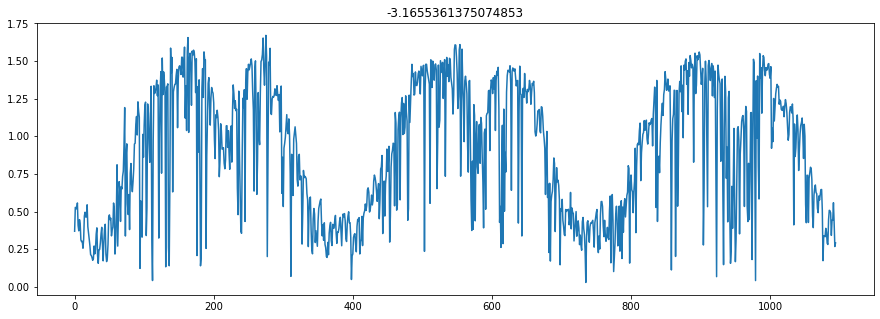

In [ ]:
### 시계열적인 특성으로 원데이터를 나누어 시계열적인 예측에 비해 얼마나 크고 작은지를 수치화함 ## 
### 나머지 변수들로 얼마나 크고 작은지를 예측후 시계열적특성을 곱하여 다시 복원 ###

plt.figure(figsize=(15,5))
plt.plot(y)
plt.title(f'{adfuller(y)[0]}')
plt.show()

In [ ]:
traincopy['y'] = y
traincopy.corr()['y']

precipitation    -0.286546
temp_mean         0.686185
temp_highest      0.734728
temp_lowest       0.625425
PM10             -0.194406
PM2.5            -0.224344
humidity         -0.020957
sunshine_sum      0.390129
sunshine_rate     0.212603
wind_mean        -0.127811
wind_max         -0.131685
rental            0.643366
t                 0.076731
year              0.006260
weekday          -0.052455
month             0.213976
pm_10            -0.166165
pm_25            -0.198591
temp_ma          -0.161806
temp_diff        -0.641813
windchill_mean    0.686038
windchill_max     0.734382
ratio             0.711795
sun               0.568550
discomfort        0.662821
holiday          -0.078362
y                 1.000000
Name: y, dtype: float64

In [ ]:
### custom Dnn 모델 정의 변수들의 직접적인 연결을 위해서 ###

from tensorflow.keras.layers import Dense, Flatten, Activation, Input, BatchNormalization, LeakyReLU, ReLU, Dropout, Concatenate, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import load_model

def make_model(size1, size2):
  input_layer = Input(shape=(X.shape[1],))
  hidden = Dense(size1, activation=None, kernel_initializer='he_normal')(input_layer)
  hidden = BatchNormalization()(hidden)  
  hidden = LeakyReLU()(hidden)
  hidden = Dense(size2, activation=None, kernel_initializer='he_normal')(hidden)
  hidden = LeakyReLU()(hidden)
  hidden = BatchNormalization()(hidden)  
  concat = Concatenate()([input_layer, hidden])
  output = Dense(1)(concat)

  model = Model(inputs=[input_layer], outputs=[output])
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_squared_error'])
  return model

In [ ]:
### 여러모델 앙상블 ###
### 일반 회귀 (딥러닝 기반)과 트리기반 회귀를 같이 앙상블


skf = StratifiedKFold(n_splits=ns, shuffle=True, random_state=rs)
# skf = KFold(n_splits=ns, shuffle=True, random_state=rs)

nmae_list = []
test_pred = []
pred_validations = np.zeros(train.shape[0])

for fold,(train_index, val_index) in enumerate(skf.split(X, fold_criteria)):
    test_X = test_X_.copy()
    print("========== fold %d ==========" %(fold+1))
    target_pred = []   
    val_pred_dict = {}
    x_train, x_val, y_train, y_val = X[train_index], X[val_index], np.array(y)[train_index], np.array(y)[val_index]
    tt_train, tt_val, or_train, or_val = np.array(prohet_train)[train_index], np.array(prohet_train)[val_index], np.array(original_rental)[train_index], np.array(original_rental)[val_index]

    ### XGBRegressor ###
    model = XGBRegressor(objective='reg:squarederror', random_state = rs, n_estimators=ne, learning_rate=lr ,early_stopping_rounds=es, max_depth=md, eval_set=(x_val,y_val),)
    model.fit(x_train, y_train, verbose=0)
    test_pred.append(model.predict(test_X) * np.array(prohet_test)) # test set pred 결과 저장
    val_pred_dict['XGB'] = val_pred_dict.get('XGB', model.predict(x_val) * tt_val)
    
    ### LGBMRegressor ###
    model = LGBMRegressor(random_state = rs, n_estimators=ne, learning_rate=lr, early_stopping_rounds=es, max_depth=md,)
    model.fit(x_train, y_train, eval_set=(x_val,y_val), verbose=0)
    test_pred.append(model.predict(test_X) * np.array(prohet_test)) # test set pred 결과 저장
    val_pred_dict['LGB'] = val_pred_dict.get('LGB', model.predict(x_val) * tt_val)

    ### MLPRegressor ###
    model = MLPRegressor(random_state = rs, hidden_layer_sizes=(128,)) 
    model.fit(x_train, y_train)
    test_pred.append(model.predict(test_X) * np.array(prohet_test)) # test set pred 결과 저장
    val_pred_dict['MLP'] = val_pred_dict.get('MLP', model.predict(x_val) * tt_val)

    ### custom_dnn ###
    model = make_model(128,16)
    filepath = f"DNN_{fold}.hdf5"
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
    history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks, verbose=0)
    model = load_model(filepath)
    test_pred.append(model.predict(test_X, verbose=0).reshape(-1) * np.array(prohet_test)) # test set pred 결과 저장
    val_pred_dict['DNN'] = val_pred_dict.get('DNN', model.predict(x_val, verbose=0).reshape(-1) * tt_val)

    proba_list = list(val_pred_dict.values())
    proba = proba_list[0].copy()
    
    for name, pred in val_pred_dict.items():
        print(f'{name} : {NMAE(or_val, pred):.4f}')
    
    for i in range(1, len(proba_list)):
        proba += proba_list[i]
    result = proba/len(proba_list)
    
    nmae = NMAE(or_val, result)
    nmae_list.append(nmae)
    
    print("NMAE : %0.4f\n" %(nmae))
    pred_validations[val_index] = result
print("\n==============================")
print(f'\ntotal mean_nmae : {np.mean(nmae_list):.4f}')

========== fold 1 ==========
XGB : 0.1119
LGB : 0.1334
MLP : 0.1602
DNN : 0.1931
NMAE : 0.1036

========== fold 2 ==========
XGB : 0.1633
LGB : 0.1643
MLP : 0.2040
DNN : 0.2118
NMAE : 0.1752

========== fold 3 ==========
XGB : 0.1171
LGB : 0.1164
MLP : 0.1561
DNN : 0.1832
NMAE : 0.1142

========== fold 4 ==========
XGB : 0.1139
LGB : 0.1123
MLP : 0.1493
DNN : 0.1630
NMAE : 0.1093

========== fold 5 ==========
XGB : 0.1098
LGB : 0.1095
MLP : 0.1326
DNN : 0.1497
NMAE : 0.1021

========== fold 6 ==========
XGB : 0.1108
LGB : 0.1178
MLP : 0.1334
DNN : 0.1524
NMAE : 0.1091

========== fold 7 ==========
XGB : 0.1148
LGB : 0.1185
MLP : 0.1543
DNN : 0.1961
NMAE : 0.1233

========== fold 8 ==========
XGB : 0.2448
LGB : 0.2187
MLP : 0.2841
DNN : 0.2523
NMAE : 0.2319

========== fold 9 ==========
XGB : 0.1512
LGB : 0.1443
MLP : 0.1870
DNN : 0.2673
NMAE : 0.1663



total mean_nmae : 0.1372


rain_scale 0 : 0.1371
rain_scale 1 : 0.1276
rain_scale 2 : 0.1302
rain_scale 3 : 0.1381
rain_scale 4 : 0.1453


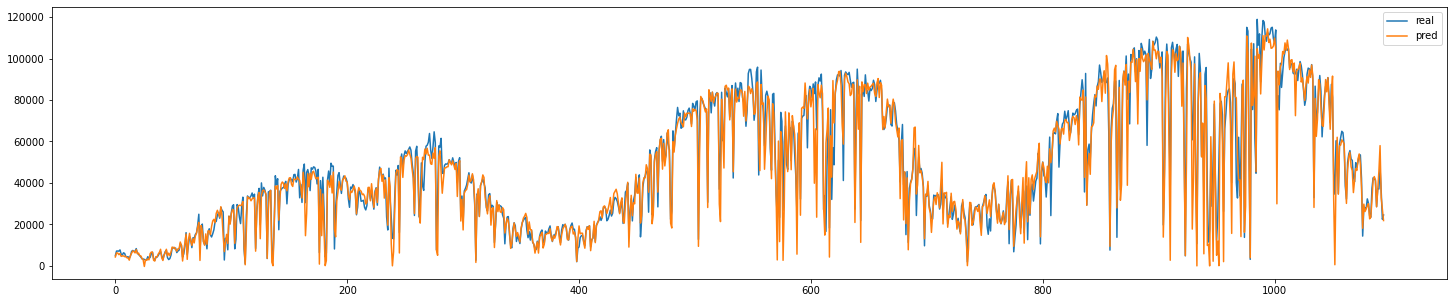

In [ ]:
### 원데이터를 복원하고 시계열적인 특성을 복원 + 비오는 날에대해서 가중치를 곱하여 보정 ###

ww = my_minmax(train['precipitation'])

for i in range(5):
  print(f'rain_scale {i} : {NMAE(original_rental, pred_validations*(ww**i)):.4f}')

plt.figure(figsize=(25,5))
plt.plot(train['rental'], label='real')
plt.plot(pred_validations*(ww**2), label='pred')
plt.legend()
plt.show()

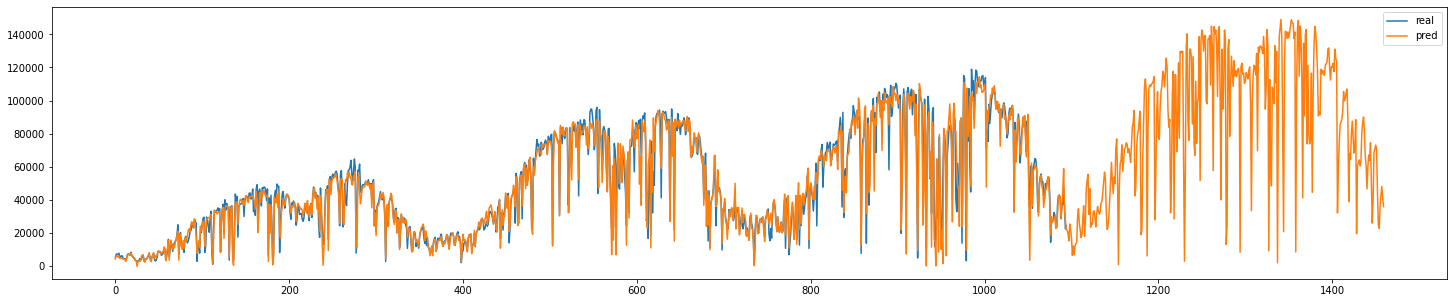

In [ ]:
### 원데이터를 복원하고 시계열적인 특성을 복원 + 비오는 날에대해서 가중치를 곱하여 보정 ###
### 테스트셋에 대해서는 가중치를 제곱하여곱해줌 이것이 성능이 더 좋았음###

test_pred_result = test_pred[0].copy()
for i in range(1, len(test_pred)):
    test_pred_result += test_pred[i]
    
test_pred_result = test_pred_result/len(test_pred)

ww2 = my_minmax(test['precipitation'])
final_result = test_pred_result*(ww2**2)

plt.figure(figsize=(25,5))
plt.plot(train['rental'], label='real')
plt.plot(np.concatenate([pred_validations*(ww**1),final_result]), label='pred')
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['rental'] = final_result
submission.to_csv('./resultttt.csv', index=False) 